# Simulating the Beer-Lambert Law with Tidy3D

In this tutorial, we demonstrate how to translate the absorption coefficient parameter ($\alpha$ [$\text{cm}^{-1}$]) into a Tidy3D [Medium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Medium.html) and calculate volumetric power absorption using a 3D [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) and [PermittivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PermittivityMonitor.html).

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Creating a Lossy Medium

Tidy3D follows the $e^{-\omega t}$ convention, in which losses are represented by a positive imaginary part of the refractive index, here denoted as $k$:

$\tilde{n} = n + i k$

We can relate $k$ to the absorption coefficient from the Beer-Lambert law:

$I = I_0 e^{-\alpha z}$

where:

$k = \frac{\lambda \alpha}{4\pi} \times 10^{-4}$ (using $\lambda$ in microns and $\alpha$ in cm⁻¹)

An important consideration is that Tidy3D uses microns (µm) as distance units, while $\alpha$ is generally given in cm⁻¹.

With the $k$ value, we can define a lossy medium using the [`td.Medium.from_nk`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Medium.html#tidy3d.Medium.from_nk) method.

Let’s consider a medium with a real refractive index of 3 and $\alpha = 0.5$ $µ\text{m}^{-1}$.


In [8]:
# Define the central wavelength and frequency
wvl0 = 1.5
freq0 = td.C_0 / wvl0

n = 3
alpha = 0.5  # absorption in 1/µm
k = alpha * wvl0 / (4 * np.pi)
medium = td.Medium.from_nk(n=n, k=k, freq=freq0)

### Relating *k* with Conductivity

Alternatively, we can relate the complex refractive index with the complex permittivity and calculate the conductivity $\sigma$.

$\tilde{n} = n + i\kappa$

$\varepsilon_r = \tilde{n}^2 = (n^2 - \kappa^2) + i(2n\kappa)$

$\varepsilon'' = 2n\kappa$

$\sigma(\omega) = \omega \varepsilon_0 \varepsilon'' = 2\omega \varepsilon_0 n \kappa$

$\sigma(\omega) = \frac{4\pi \varepsilon_0 c}{\lambda} n \kappa$ [S/µm]

Again, following Tidy3D’s unit convention, the **conductivity is in units of S/µm.**

With the conductivity value, we can create the same medium using the regular [td.Medium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Medium.html) class.

As we can see, the two methods are equivalent.

In [ ]:
# Equivalent conductivity-based definition to verify consistency
# Note that epsilon is the vacuum permittivity, not the relative permittivity
sigma = 4 * np.pi * td.EPSILON_0 * td.C_0 * k * n / wvl0
medium2 = td.Medium(permittivity=n**2, conductivity=sigma)

print(f"medium  conductivity: {medium.conductivity:.6f}")
print(f"medium2 conductivity: {medium2.conductivity:.6f}")

medium  conductivity: 0.003982
medium2 conductivity: 0.003982


## Simulating the Beer-Lambert Law

With the lossy medium defined, we can use it as the background medium in a simulation and calculate the absorbed power using the following definition:

$P_{abs} = \tfrac{1}{2} \, \omega \, \varepsilon_0 \, \varepsilon'' \, |E|^2 = \tfrac{1}{2} \, \sigma \, |E|^2$

First, let’s define the simulation object.

In [10]:
sim_size = (1, 1, 11)
sim_center = (0, 0, 4.5)

run_time = 1e-12
min_steps_per_wvl = 30

# Broadband plane wave incident along +z
source_time = td.GaussianPulse(freq0=freq0, fwidth=0.2 * freq0)
source = td.PlaneWave(
    center=(0, 0, 0),
    size=(sim_size[0], sim_size[1], 0),
    source_time=source_time,
    direction="+",
)

# Periodic lateral boundaries and absorbing PML along propagation
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
)

# 2D slice to inspect field decay through the bulk
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 0, td.inf), freqs=[freq0], name="field_monitor"
)

# Bounding box enclosing the integration region for absorbed power
abs_monitor_geometry = td.Box.from_bounds(rmin=(-1e3, -1e3, 0), rmax=(1e3, 1e3, 1e3))

# Store volume fields for absorption post-processing
abs_field_monitor = td.FieldMonitor(
    center=abs_monitor_geometry.center,
    size=abs_monitor_geometry.size,
    freqs=[freq0],
    name="abs_field_monitor",
)

# Matching permittivity sample to extract the imaginary part
abs_permittivity_monitor = td.PermittivityMonitor(
    center=abs_field_monitor.center,
    size=abs_field_monitor.size,
    freqs=abs_field_monitor.freqs,
    name="abs_permittivity_monitor",
)


# Automatic mesh obeying the min steps per wavelength target
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=min_steps_per_wvl,
    override_structures=[],
)

# Assemble the simulation object with the lossy background medium
sim = td.Simulation(
    size=sim_size,
    center=sim_center,
    grid_spec=grid_spec,
    medium=medium,
    sources=[source],
    monitors=[field_monitor, abs_field_monitor, abs_permittivity_monitor],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

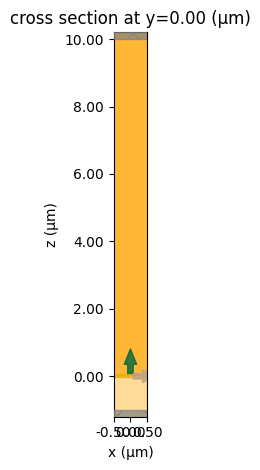

In [11]:
# Visual check of the structure cross-section at y = 0
sim.plot(y=0)
plt.show()

Now we can run the simulation and process the data.

In [12]:
# Submit the simulation to Tidy3D Cloud
sim_data = web.run(sim, task_name="absorption_calculation")

18:48:19 -03 Created task 'absorption_calculation' with resource_id             
             'fdve-593f57f7-1490-438d-91a9-76268f2b65e8' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=862571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-593f57f7-1490-438d-91a9-76268f2b65e8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=70059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-593f57f7-1490-438d-91a9-76268f2b65e8\taskId]8;;\]8;id=862571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-593f57f7-1490-438d-91a9-76268f2b65e8\=]8;;\]8;id=867890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-593f57f7-1490-438d-91a9-76268f2b65e8\fdve]8;;\]8;id=862571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-593f57f7-1490-438d-91a9-76268f2b65e8\-593f57f7-149]8;;\
             ]8;id=862571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-593f57f7-1490-438d-91a9-76268f2b65e8\0-438d-91a9-76268f2b65e8']8;;\.

             Task folder: ]8;id=975916;https://tidy3d.simulation.cloud/folders/folder-f9e994c1-6315-4b44-af3a-c2cb1435b23a\'default']8;;\.

Output()

18:48:22 -03 Estimated FlexCredit cost: 0.026. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:48:23 -03 status = success

Output()

18:48:29 -03 loading simulation from simulation_data.hdf5

## Data Processing

First, let’s plot the fields, where we can observe an exponential decay in the field intensity.

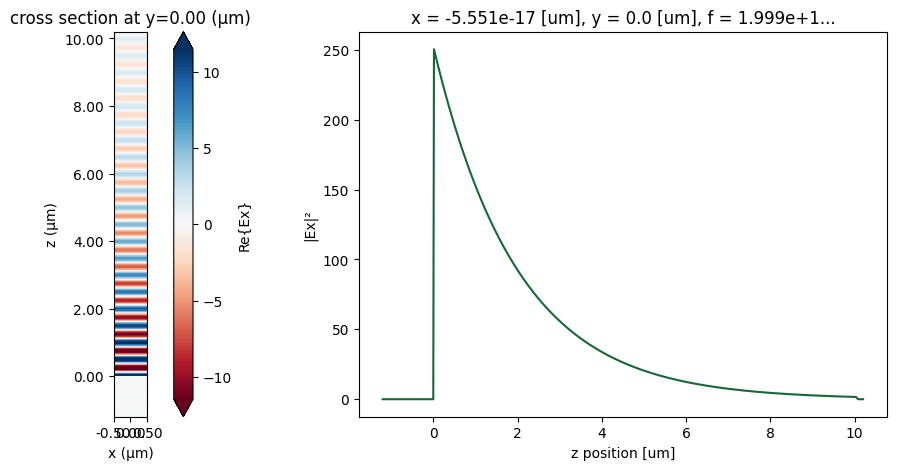

In [13]:
# Field snapshot and intensity decay along z
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sim_data.plot_field("field_monitor", "Ex", "real", ax=ax[0])
(np.abs(sim_data["field_monitor"].Ex) ** 2).sel(x=0, method="nearest").plot(ax=ax[1])
ax[1].set_ylabel("|Ex|²")

plt.show()

Now, we can calculate the volumetric absorbed power, using the following relation:

$P_{abs} = \tfrac{1}{2} \, \omega \, \varepsilon_0 \, \varepsilon'' \, |E|^2$

And compare with the analytical results, from Beer-Lambert law:

$I = I_0 e^{-\alpha z}$

In [14]:
# Extract field components sampled in the absorption volume
Ex = sim_data["abs_field_monitor"].Ex.squeeze(drop=True)
Ey = sim_data["abs_field_monitor"].Ey.squeeze(drop=True)
Ez = sim_data["abs_field_monitor"].Ez.squeeze(drop=True)

x = sim_data["abs_field_monitor"].Ex.x
y = sim_data["abs_field_monitor"].Ey.y
z = sim_data["abs_field_monitor"].Ez.z

# Interpolate permittivity onto the same grid to access eps''
eps_xx = sim_data["abs_permittivity_monitor"].eps_xx.interp_like(
    Ex, method="linear", kwargs={"fill_value": "extrapolate"}
)

E_square = np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2
omega = 2 * np.pi * freq0

# Compute volumetric absorbed power density and integrate over the box
P_abs_volumetric = 0.5 * omega * td.EPSILON_0 * eps_xx.imag * E_square
P_abs = P_abs_volumetric.integrate("x").integrate("y").integrate("z").squeeze()

print(f"Total absorbed power: {P_abs:.2f}")
print(f"Analytical absorbed power: {1 - np.exp(-10 * alpha):.2f}")

Total absorbed power: 0.99
Analytical absorbed power: 0.99


Finally, we compute the cumulative integral of the volumetric absorbed power along the full z-direction and directly compare the resulting energy loss with the analytical prediction given by the Beer–Lambert law.

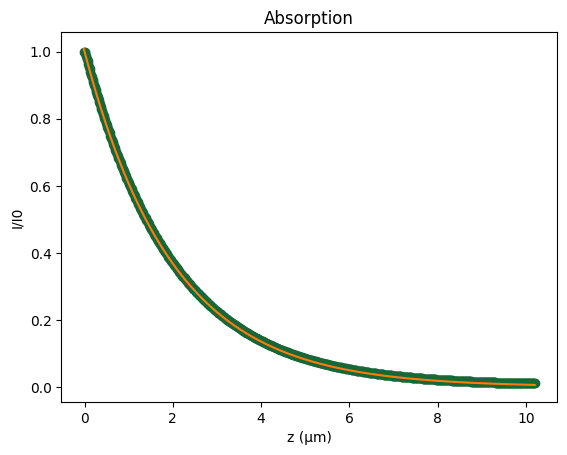

In [15]:
# Cumulative absorption along z to compare with Beer-Lambert prediction
I_z = P_abs_volumetric.integrate("x").integrate("y").squeeze()
from scipy.integrate import cumulative_trapezoid

C_z = cumulative_trapezoid(I_z, z, initial=0.0)  # [W] absorbed up to each z

P_abs = P_abs_volumetric.integrate("x").integrate("y").squeeze()
I_analytical = np.exp(-z * alpha)
I = 1 - C_z


fig, ax = plt.subplots()

ax.plot(z, I, "o", label="Simulated")
ax.plot(z, I_analytical, label="Analytical")

ax.set_xlabel("z (µm)")
ax.set_ylabel("I/I0")
ax.set_title("Absorption")

plt.show()